In [1]:
!pip install rich
!pip install wandb
from google.colab import drive
drive.mount('/content/drive')


     |████████████████████████████████| 174kB 7.7MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 1.8MB 9.2MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 163kB 24.1MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 133kB 15.9MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=60e026b516d6134d72f3bf7b6742f03c33f8a2d570eba93a9070a73760d6bd50
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.4-cp36-none-any.whl size=74841 sha256=be94e7d756063cc657f3cb56ea7685d5f073af012de51e1f29c98b7a429fd74a
  Stored in directory: /root/.cache/pip/wheels/9e/11/04/5160b8815b0cc7cf574bdc6d053e510169ec264c8791b4ec3a
  Created wheel for patht

In [2]:
import os
import torch
import torchvision
# import torchvision.transforms as transforms
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from rich.progress import track
from skimage import io, transform


seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

batch_size = 64
img_size = 180

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print('Running on GPU: {}.'.format(torch.cuda.get_device_name()))
else:
    print('Running on CPU.')

Running on GPU: Tesla T4.


In [7]:
!mv data alldata
## !cp drive/MyDrive/Data\ ECE324/fulldata.zip .

In [8]:
def load_data_first_time(img_size, desired=None):
    preset_mean = [0.0, 0.0, 0.0]
    preset_std = [0.0, 0.0, 0.0]

    transform = transforms.Compose(
        [
         transforms.Resize(img_size),
         transforms.CenterCrop(img_size),
#          transforms.Grayscale(),
         transforms.ToTensor()
         ])
#     transforms.Normalize(preset_mean, preset_std)

    imageDataset = torchvision.datasets.ImageFolder(root='./alldata', transform=transform)
    
    random.shuffle(imageDataset.imgs)


    print ("Sample Images:", imageDataset.imgs[:5])
    print ("Labels:", imageDataset.class_to_idx)

    num_classes = len(imageDataset.classes)

    print ("Number of images:",len(imageDataset))
    
    return imageDataset




In [10]:


def getMeanStd(imageDataset):
    nimages = len(imageDataset)
    mean = 0.
    std = 0.
    
    sss = np.empty((3,))
#     print (np.array(imageDataset[5][0]).shape)
#     immg = np.array(imageDataset[5][0])#.reshape(img_size, img_size, 3)
#     print (imageDataset.imgs[5], immg.shape)
#     depth, rows, cols = immg.shape
#     immg = immg.reshape(rows, cols, depth)
#     plt.imshow(immg, cmap="gray")
#     plt.show()
    
#     from PIL import Image
#     im = Image.open(imageDataset.imgs[5][0])
#     display(im)

#     return
    
    count  =0
    for img, _ in imageDataset:
#         count +=1
#         if count%100==0:
#             print (count, sss.shape)
#         if count%1000 ==0:
#             print (sss.std(0))
            
        arr = np.array(img)
#         print (arr.shape)
#         print (arr.mean(1).mean(1))
#         mean += arr.mean(1).mean(1) #arr.mean(1).sum(1) # this one
        mean += images.mean(2).sum(0)
#         s = arr.reshape(3, -1).std(1)
        
#         sss = np.vstack((sss, arr.reshape(-1, 3)))
#         sss.append(arr.reshape(-1, 3))
#         print (np.multiply(s,s).shape)
#         std += np.multiply(s,s)
        #std += arr.std(1).sum(1)
        
    mean /= nimages
#     std /= nimages
#     print (std.shape, "sdfdsf")
#     std = np.sqrt(std)
    
#     print ("loop complete")
    
#     print ("STD:", sss.std(0))

    return {"mean": mean,"std": std}

imageDataset = load_data_first_time(img_size)
classes = imageDataset.classes

# getMeanStd(imageDataset)



Sample Images:
[
    ('./alldata/Raj/face103_9ae3f545-2a9a-11eb-9df6-002432182720.jpg', 5),
    ('./alldata/Leonard/face314_12fee35b-2a9d-11eb-9690-002432182720.jpg', 2),
    ('./alldata/Sheldon/face602_4163f354-2aa0-11eb-8ae7-002432182720.jpg', 6),
    ('./alldata/Extra/face477_22118ad6-2a9f-11eb-971f-002432182720.jpg', 0),
    ('./alldata/Extra/face209_e12c401b-2a9b-11eb-978b-002432182720.jpg', 0)
]
Labels:
{
    'Extra': 0,
    'Howard': 1,
    'Leonard': 2,
    'Other': 3,
    'Penny': 4,
    'Raj': 5,
    'Sheldon': 6
}
Number of images: 6355


In [11]:
loader = torch.utils.data.DataLoader(imageDataset,
                         batch_size=32,
                         shuffle=False)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*180*180))

In [12]:
mean, std

(tensor([0.3830, 0.2347, 0.2191], device='cpu'),
 tensor([0.2028, 0.1550, 0.1607], device='cpu'))

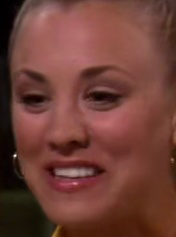

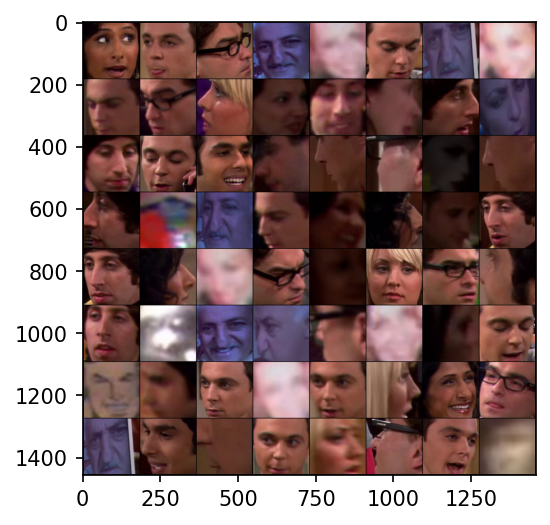

In [13]:
from PIL import Image
im = Image.open('./alldata/Penny/face458_c44b8e1e-2a9e-11eb-aff2-002432182720.jpg')
display(im)

def imshow(img, normalize=True):
    nimg = img.numpy()
    if normalize:
        nimg[0, :, :] += 0.3831
        nimg[1, :, :] += 0.2346
        nimg[2, :, :] += 0.2189
    
    plt.imshow(np.transpose(nimg, (1, 2, 0)))
    plt.show()


# get some random training images

trainloader = torch.utils.data.DataLoader(imageDataset, batch_size=batch_size,shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images), False)
# print labels
# print(' '.join('%5s' % classes[labels[j]][0] for j in range(batch_size)))

In [14]:
def load_fulldata(img_size, desired=None):
#     means = [22.977926, 14.072051, 13.135243]
#     stds = [6.766082 , 4.9459076, 4.655467] 
    
    means = [0.3831, 0.2346, 0.2189] # [68.95092 , 42.220562, 39.40766 ] # [22.977901, 14.072001, 13.135235]
    stds =  [0.2026, 0.1548, 0.1604] #[12.395633,  9.082816,  8.674709] #[20.493658, 15.029254, 14.170863] # [6.7660933, 4.9459095, 4.655468 ]
#     [0.3830612 , 0.23455817, 0.21893184] #
#     [0.19234892, 0.19233663, 0.19233346] #
#     transform = transforms.Compose([
#         transforms.Resize(img_size),
#         transforms.CenterCrop(img_size),
#         transforms.ToTensor(),
#         transforms.Normalize(means, stds)
#         ])

    transform = transforms.Compose(
        [
            transforms.Resize(img_size),
            transforms.CenterCrop(img_size),
#             transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ])

    fulldataset = datasets.ImageFolder(root='./alldata', transform = transform)
#     fulldataset = datasets.ImageFolder(root='./sample_data', transform = transform)
    random.shuffle(fulldataset.imgs)
    
    if desired:
        for i in range(len(fulldataset)):
            img , label = fulldataset.imgs[i]
            if label == desired:
                fulldataset.imgs[i] = (img, 1)
            else:
                fulldataset.imgs[i] = (img, 0)
    
    print (fulldataset.imgs[:15])
    
    

    return fulldataset

# fulldataset = load_fulldata(img_size)




In [15]:

def get_loaders(data):
    n = len(data)
    n_train = int(0.7 * n)
    n_valid = int(0.15 * n)
    n_test  = int(0.15 * n)
    
    random.shuffle(data.imgs)

    train_set = torch.utils.data.Subset(data, range(0, n_train))
    valid_set = torch.utils.data.Subset(data, range(n_train, n_train + n_valid))
    test_set  = torch.utils.data.Subset(data, range(n_train + n_valid, n))
    
    print (batch_size)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=True)
    
    return train_loader, valid_loader, test_loader



# len(train_loader), len(valid_loader), len(test_loader)


In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_norm1 = nn.BatchNorm2d(20)
        self.conv_norm2 = nn.BatchNorm2d(20)
        self.conv_norm3 = nn.BatchNorm2d(20)
        self.conv_norm4 = nn.BatchNorm2d(20)
        
        self.conv_norm1.track_running_stats=False
        self.conv_norm2.track_running_stats=False
#         self.conv_norm3.track_running_stats=False
#         self.conv_norm4.track_running_stats=False
        

        self.conv1 = nn.Conv2d(3,  20, 3)
        self.conv2 = nn.Conv2d(20, 20, 3)
#         self.conv3 = nn.Conv2d(20, 20, 3)
#         self.conv4 = nn.Conv2d(20, 20, 3)
        
        self.fc1 = nn.Linear(20*43*43, 400)
        self.fc2 = nn.Linear(400, 7)

        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.conv_norm2(self.conv2(x))))
#         x = self.pool(F.relu(self.conv_norm3(self.conv3(x))))
#         x = self.pool(F.relu(self.conv_norm4(self.conv4(x))))
#         print ("x shape", x.shape)
        x = x.view(-1,20*43*43)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [17]:
def evaluate(model, v, show, loss_fnc, desired=False, sensitivity=False):
    total = 0
    correct = 0
    vloss = 0
    
    ones = torch.ones([batch_size], dtype=torch.long)
    neg_ones = -1 * ones
    twos = ones + 1
    
    TPs = 0.
    FPs = 0.
    FNs = 0.
    
    with torch.no_grad():
        for data in v:
            images, labels = data
            outputs = model(images.type(torch.cuda.FloatTensor))
            labels = labels.type(torch.cuda.LongTensor)

            vloss += loss_fnc(input=outputs.squeeze(), target=labels)
            
            
                
                

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()
            
            if sensitivity:
                TPs += (predicted + labels == twos[:len(labels)]).sum().item()
#                 FPs += (predicted - labels == neg_ones).sum().item()
                FNs += (predicted - labels == ones[:len(labels)]).sum().item()

            lookup = classes

            if desired:
                lookup = ["Extra", classes[desired]]

            
            if show:
                for i in range(len(predicted)):
                    if predicted[i] != labels[i]:
                        imshow(images[i])
                        
#                         imshow(torchvision.utils.make_grid(imm))


#                         plt.imshow(torchvision.utils.make_grid(images[i].reshape(180, 180, 3))) #.reshape(60, 60, 3)
#                         plt.show()

                        print (">>>>>>", lookup[predicted[i]])
                        print ("Truth:", lookup[labels[i]])
    
    if sensitivity:
        if 
        return TPs/(TPs+FNs), vloss.item()/len(v)
        
    return float(correct)/float(total), vloss.item()/len(v)

In [18]:
fulldataset = load_fulldata(img_size)
train_loader, valid_loader, test_loader = get_loaders(fulldataset)
# print (len(train_loader), len(valid_loader), len(test_loader))

model = Net()
if torch.cuda.is_available():
    model = model.cuda()
    
    
lr = 0.03 # 96.6%
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


# optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fnc = nn.CrossEntropyLoss().cuda()
# loss_fnc = nn.MSELoss().cuda()
epochs = 30


losses = []
vlosses = []
vaccs = []
accs = []
tlosses = []
k=0

from time import time

start = time()
best_vacc = 0

print ("start training")
for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = model(inputs.type(torch.cuda.FloatTensor))
        
        labels = labels.type(torch.cuda.LongTensor)
        loss = loss_fnc(input=outputs.squeeze(), target=labels)
        
        loss.backward()
        optimizer.step()
        
        
    if (epoch)%1 == 0:
        model.eval()
        vacc, vloss = evaluate(model, valid_loader, False, loss_fnc, sensitivity=True)
        model.train()
#         acc, tloss = evaluate(model, train_loader, False, loss_fnc)

#         accs.append(acc)
#         tlosses.append(tloss)
#         vaccs.append(vacc)
#         losses.append(loss)
        vlosses.append(vloss)
        
#         print('[%d, %.1f] loss: %.4f, acc: %.1f **********' % (epoch + 1, time()-start, tloss, acc*100))
        if vacc > best_vacc:
            best_vacc = vacc
            print('[%d, %.1f] loss: %.4f, acc: %.1f **********' % (epoch + 1, time()-start, vloss, vacc*100))
        else:
            print('[%d, %.1f] loss: %.4f, acc: %.1f' % (epoch + 1, time()-start, vloss, vacc*100))

print ("Batch size", batch_size)
print('Total Time:', time()-start)

[
    ('./alldata/Other/face175_77c3cbab-2a9b-11eb-b5fe-002432182720.jpg', 3),
    ('./alldata/Extra/face345_8dcb7b51-2a9d-11eb-84cb-002432182720.jpg', 0),
    ('./alldata/Extra/face31_d34a9f92-2a99-11eb-9117-002432182720.jpg', 0),
    ('./alldata/Extra/face167_68dc9932-2a9b-11eb-9d22-002432182720.jpg', 0),
    ('./alldata/Sheldon/face323_4c408000-2a9d-11eb-809d-002432182720.jpg', 6),
    ('./alldata/Raj/face172_6eec3ff6-2a9b-11eb-ad2e-002432182720.jpg', 5),
    ('./alldata/Other/face381_fe387c61-2a9d-11eb-9cd0-002432182720.jpg', 3),
    ('./alldata/Extra/face140_1105c2e9-2a9b-11eb-94a0-002432182720.jpg', 0),
    ('./alldata/Sheldon/face42_efcea886-2a99-11eb-bee4-002432182720.jpg', 6),
    ('./alldata/Other/face50_00e559f8-2a9a-11eb-945d-002432182720.jpg', 3),
    ('./alldata/Howard/face82_543e3e11-2a9a-11eb-af22-002432182720.jpg', 1),
    ('./alldata/Extra/face589_33c39eab-2aa0-11eb-937e-002432182720.jpg', 0),
    ('./alldata/Sheldon/face55_0e7f07fc-2a9a-11eb-bf31-002432182720.jpg', 6

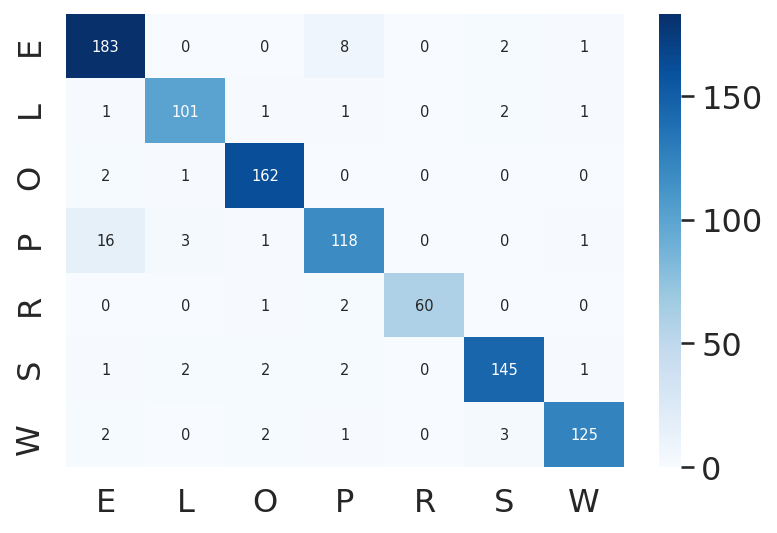

(0.9381551362683438, 0.2873502731323242)

In [19]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for data in test_loader:
        images, labels = data
        
        for i in range(len(labels)):
            y_true.append(labels[i])
        
        outputs = model(images.type(torch.cuda.FloatTensor))
        labels = labels.type(torch.cuda.LongTensor)
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred += list(predicted.float())
        
y_true = [int(c) for c in y_true]
y_pred = [int(c) for c in y_pred]

conf_matrix = confusion_matrix(y_true, y_pred)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf_matrix, index = [i for i in "ELOPRSW"],
                  columns = [i for i in "ELOPRSW"])


# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 7}, fmt='g', cmap="Blues") # font size
plt.savefig('Confusion.jpg')
plt.show()

evaluate(model, test_loader, False, loss_fnc)
# for a,b in zip(y_pred, y_true):
#     if a != b:
#         print (a,b)

[
    ('./alldata/Howard/face466_0479189c-2a9f-11eb-a98b-002432182720.jpg', 0),
    ('./alldata/Leonard/face242_4c8bfc25-2a9c-11eb-98de-002432182720.jpg', 0),
    ('./alldata/Raj/face166_65d5d8ca-2a9b-11eb-b205-002432182720.jpg', 0),
    ('./alldata/Extra/face439_8af1a571-2a9e-11eb-bc8f-002432182720.jpg', 0),
    ('./alldata/Sheldon/face284_cdc85d11-2a9c-11eb-8eea-002432182720.jpg', 0),
    ('./alldata/Sheldon/face211_de005b46-2a9b-11eb-a1f1-002432182720.jpg', 0),
    ('./alldata/Extra/face209_ed1819ba-2a9b-11eb-9772-002432182720.jpg', 0),
    ('./alldata/Raj/face359_9f6782b7-2a9d-11eb-90af-002432182720.jpg', 0),
    ('./alldata/Raj/face75_43b96e27-2a9a-11eb-b9b0-002432182720.jpg', 0),
    ('./alldata/Penny/face532_990fbd5b-2a9f-11eb-af17-002432182720.jpg', 1),
    ('./alldata/Other/face609_57a78c63-2aa0-11eb-94dc-002432182720.jpg', 0),
    ('./alldata/Leonard/face448_a5976064-2a9e-11eb-82bc-002432182720.jpg', 0),
    ('./alldata/Other/face56_10f351a0-2a9a-11eb-8b68-002432182720.jpg', 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


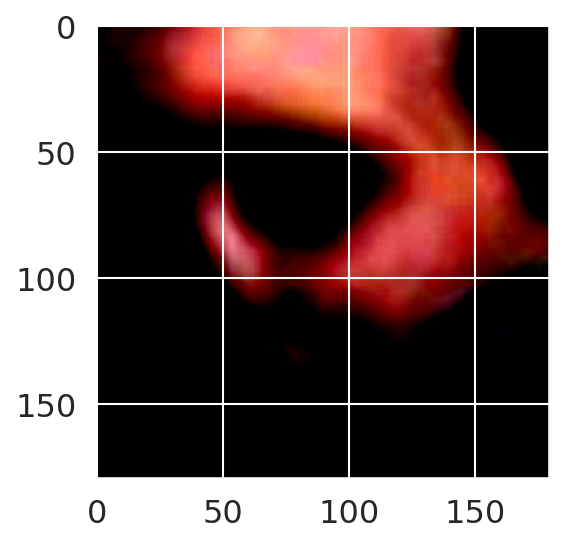

In [20]:
# {'Extra': 0, 'Leonard': 1, 'Other': 2, 'Penny': 3, 'Raj': 4, 'Sheldon': 5, 'Wolowitz': 6}

desired =  4
fulldataset = load_fulldata(img_size, desired)
print (fulldataset)
train_loader, valid_loader, test_loader = get_loaders(fulldataset)
# t,v,q = get_loaders(fulldataset)

# print (len(train_loader), len(valid_loader), len(test_loader))
# print (len(t), len(v), len(q))
d = iter(train_loader)

images, labels = d.next()
# print (labels)
# show images
imm = images[0]# - images[0].min()
# imm[imm < 0] = 0

# print (imm)

# print (fulldataset)
imshow(torchvision.utils.make_grid(imm))

In [29]:
!pip install ptflops
from ptflops import get_model_complexity_info
macs, params = get_model_complexity_info(model, (3, 180, 180), as_strings=False)
# print(int(params))
print('moedl params: {} M'.format(int(params)/(10**6)))
print('model gflops: {} '.format(int(macs)*2/(10**9)))

Net(
  14.8 M, 100.000% Params, 0.062 GMac, 100.000% MACs, 
  (pool): MaxPool2d(0.0 M, 0.000% Params, 0.001 GMac, 1.260% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_norm1): BatchNorm2d(0.0 M, 0.000% Params, 0.001 GMac, 2.035% MACs, 20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv_norm2): BatchNorm2d(0.0 M, 0.000% Params, 0.0 GMac, 0.486% MACs, 20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv_norm3): BatchNorm2d(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, 20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_norm4): BatchNorm2d(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, 20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(0.001 M, 0.004% Params, 0.018 GMac, 28.483% MACs, 3, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(0.004 M, 0.024% Params, 0.027 GMac, 43.985% MACs, 20, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(14.

In [21]:
class BinaryNet(nn.Module):
    def __init__(self, hidden=32, conv_num=4):
        super(BinaryNet, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_norm1 = nn.BatchNorm2d(20)
        self.conv_norm2 = nn.BatchNorm2d(20)
        self.conv_norm3 = nn.BatchNorm2d(20)
        self.conv_norm4 = nn.BatchNorm2d(20)
        
        self.conv_norm1.track_running_stats=False
        self.conv_norm2.track_running_stats=False
        self.conv_norm3.track_running_stats=False
        self.conv_norm4.track_running_stats=False
        
#         self.conv1 = nn.Conv2d(3,  20, 3)
#         self.conv2 = nn.Conv2d(20, 20, 3)
#         self.conv3 = nn.Conv2d(20, 20, 3)
#         self.conv4 = nn.Conv2d(20, 20, 3)

        
        self.conv1 = nn.Conv2d(3,  20, 6)
        self.conv2 = nn.Conv2d(20, 20, 4)
        self.conv3 = nn.Conv2d(20, 20, 3)
        self.conv4 = nn.Conv2d(20, 20, 3)

        self.fc1 = nn.Linear(20*9*9, 400)
        self.lin_norm1 = nn.BatchNorm1d(400)
        self.fc2 = nn.Linear(400, 20)
        self.lin_norm2 = nn.BatchNorm1d(20)
        self.fc3 = nn.Linear(20, 2)
        
#         self.fc1 = nn.Linear(20, hidden)
#         self.lin_norm = nn.BatchNorm1d(hidden)
#         self.fc2 = nn.Linear(hidden, 2) # could also try to do 2 to see if there is any difference

        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.conv_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.conv_norm3(self.conv3(x))))
        x = self.pool(F.relu(self.conv_norm4(self.conv4(x))))
#         print ("shape after conv", x.shape)
#         x = x.view(-1,20)
        x = x.view(-1,20*9*9)
#         x = F.relu(self.lin_norm1(self.fc1(x)))
#         x = F.relu(self.lin_norm2(self.fc2(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
    
#         x = F.relu(self.lin_norm(self.fc1(x)))
#         x = self.fc2(x)
        
        return x
    

In [31]:


model = BinaryNet()
if torch.cuda.is_available():
    model = model.cuda()
    
    
lr = 0.0004 # 96.6%
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fnc = nn.CrossEntropyLoss().cuda()
# loss_fnc = nn.BCELoss().cuda()

# loss_fnc = nn.MSELoss().cuda()

epochs = 20


losses = []
vlosses = []
vaccs = []
accs = []
tlosses = []
k=0

from time import time

start = time()
best_vacc = 0

print ("start training")
for epoch in range(epochs):
#     model.train()
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        
        optimizer.zero_grad()
        outputs = model(inputs.type(torch.cuda.FloatTensor))
        labels = labels.type(torch.cuda.LongTensor)
        
#         print (outputs.shape, labels.shape)
        
        loss = loss_fnc(input=outputs.squeeze(), target=labels)
        
        loss.backward()
        optimizer.step()
#     print (epoch)
    if (epoch)%1 == 0:
        model.eval()
        vacc, vloss = evaluate(model, valid_loader, False, loss_fnc, sensitivity=False)
        
        acc, tloss = evaluate(model, train_loader, False, loss_fnc)
        model.train()
        
        accs.append(acc)
        tlosses.append(tloss)
        vaccs.append(vacc)
#         losses.append(loss)
        vlosses.append(vloss)
        
        print('[%d, %.1f] tloss: %.4f, tacc: %.1f' % (epoch + 1, time()-start, tloss, acc*100))
        if vacc >= best_vacc:
            best_vacc = vacc
            print('[%d, %.1f] >>>>>>>>>> loss: %.4f, acc: %.1f **********' % (epoch + 1, time()-start, vloss, vacc*100))
        else:
            print('[%d, %.1f] >>>>>>>>>> loss: %.4f, acc: %.1f' % (epoch + 1, time()-start, vloss, vacc*100))

print ("Batch size", batch_size)
print('Total Time:', time()-start)

start training
[1, 23.0] tloss: 0.2867, tacc: 93.3
[1, 23.0] >>>>>>>>>> loss: 0.2943, acc: 92.4 **********
[2, 45.8] tloss: 0.3061, tacc: 93.3
[2, 45.8] >>>>>>>>>> loss: 0.3097, acc: 92.4 **********
[3, 68.3] tloss: 0.3366, tacc: 94.6
[3, 68.3] >>>>>>>>>> loss: 0.3377, acc: 94.1 **********
[4, 90.5] tloss: 0.4168, tacc: 96.9
[4, 90.5] >>>>>>>>>> loss: 0.4143, acc: 96.6 **********
[5, 112.5] tloss: 0.2589, tacc: 96.9
[5, 112.5] >>>>>>>>>> loss: 0.2572, acc: 97.3 **********
[6, 134.1] tloss: 0.1685, tacc: 95.1
[6, 134.1] >>>>>>>>>> loss: 0.1676, acc: 94.3
[7, 155.6] tloss: 0.1522, tacc: 94.8
[7, 155.6] >>>>>>>>>> loss: 0.1523, acc: 94.5
[8, 177.2] tloss: 0.1566, tacc: 96.3
[8, 177.2] >>>>>>>>>> loss: 0.1557, acc: 96.2
[9, 198.5] tloss: 0.1280, tacc: 97.1
[9, 198.5] >>>>>>>>>> loss: 0.1275, acc: 97.2
[10, 219.8] tloss: 0.1146, tacc: 97.0
[10, 219.8] >>>>>>>>>> loss: 0.1146, acc: 97.0
[11, 241.1] tloss: 0.1371, tacc: 93.4
[11, 241.1] >>>>>>>>>> loss: 0.1450, acc: 92.7
[12, 262.4] tloss: 0.

In [28]:
from torchsummary import summary
summary(model, input_size=(3, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 178, 178]             560
       BatchNorm2d-2         [-1, 20, 178, 178]              40
         MaxPool2d-3           [-1, 20, 89, 89]               0
            Conv2d-4           [-1, 20, 87, 87]           3,620
       BatchNorm2d-5           [-1, 20, 87, 87]              40
         MaxPool2d-6           [-1, 20, 43, 43]               0
            Linear-7                  [-1, 400]      14,792,400
            Linear-8                    [-1, 7]           2,807
Total params: 14,799,467
Trainable params: 14,799,467
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.37
Forward/backward pass size (MB): 13.47
Params size (MB): 56.46
Estimated Total Size (MB): 70.30
----------------------------------------------------------------


In [ ]:
evaluate(model, train_loader, False, loss_fnc, sensitivity=True), evaluate(model, train_loader, False, loss_fnc, sensitivity=False)

((1.0, 0.00027557080611586573), (1.0, 0.0001899748225696385))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


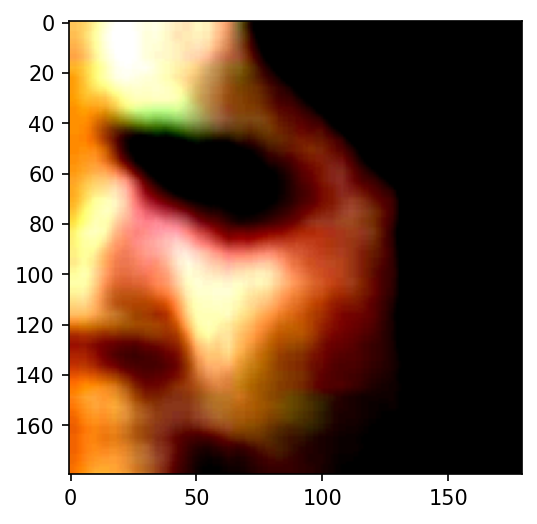

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


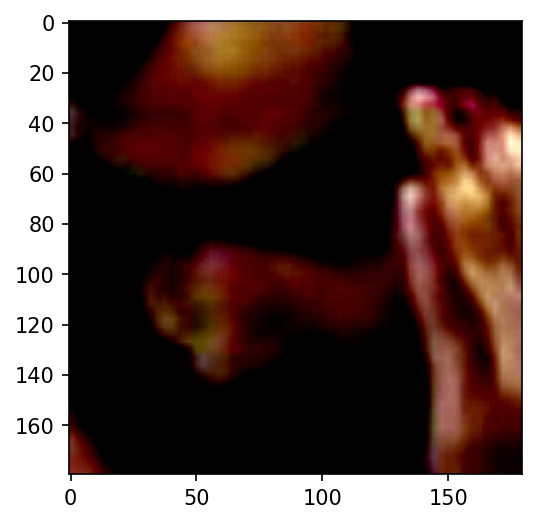

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


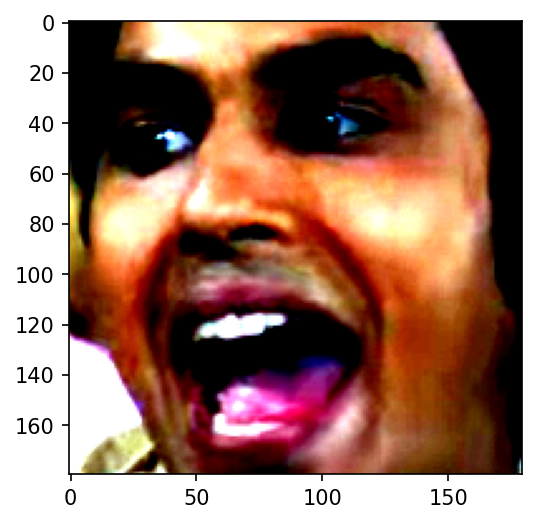

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


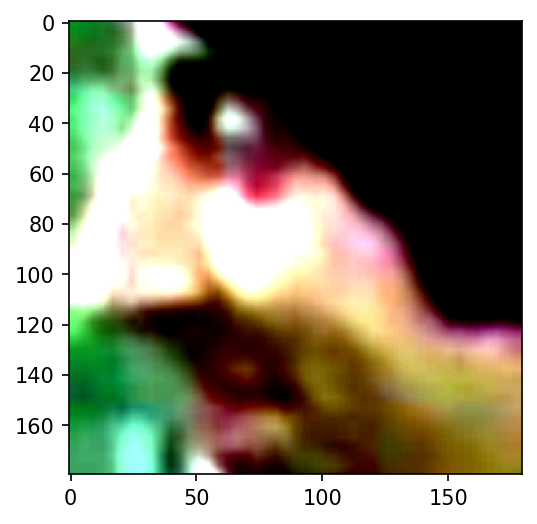

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


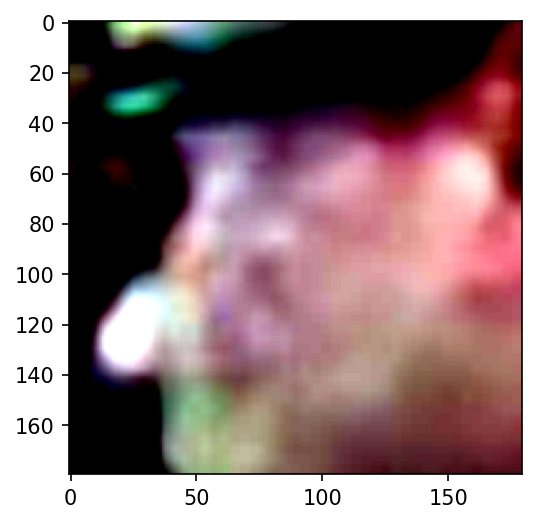

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


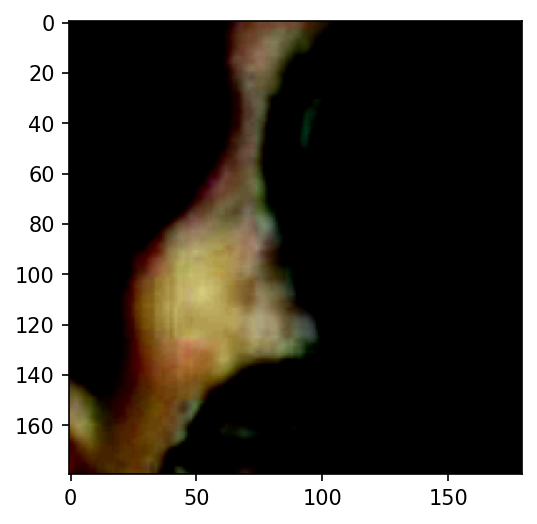

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


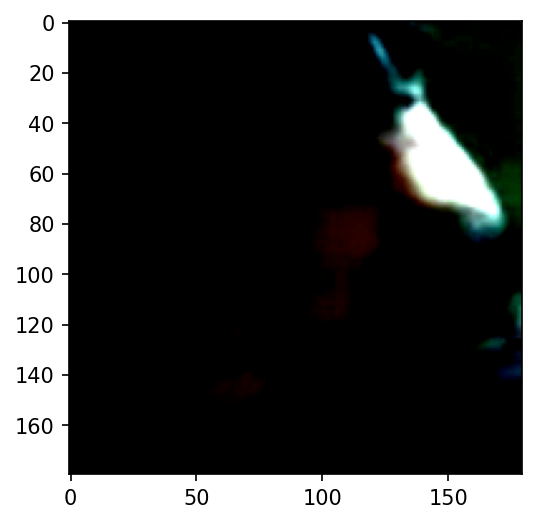

In [ ]:
model.eval()
vacc, vloss = evaluate(model, valid_loader, True, loss_fnc, desired, sensitivity=True)
print (round(vacc*100, 2), vloss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


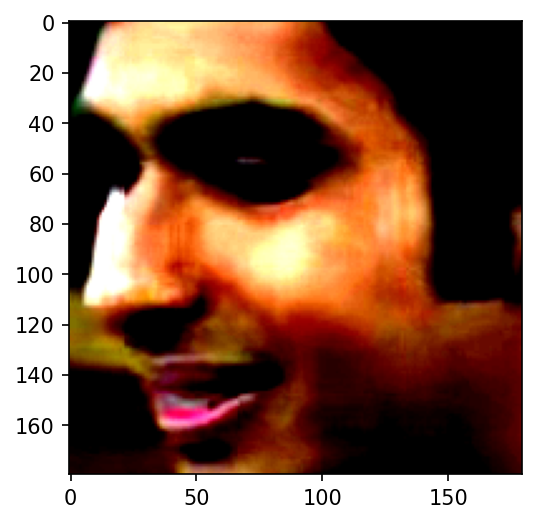

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


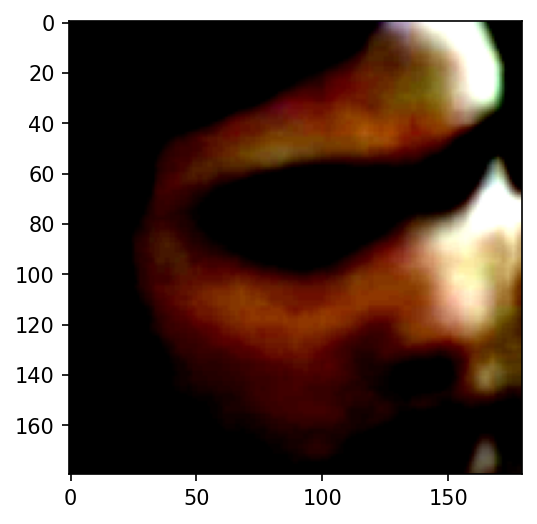

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


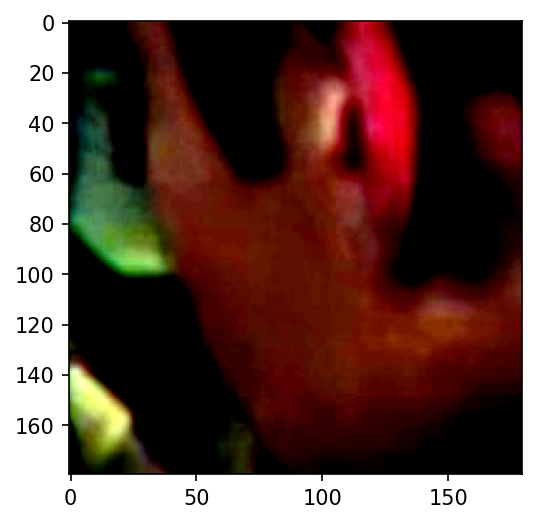

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


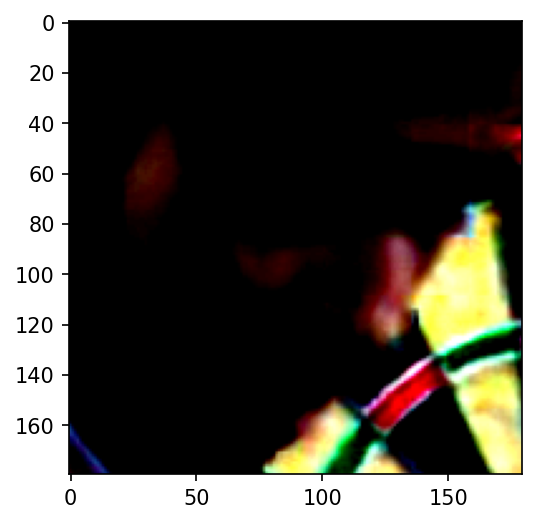

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


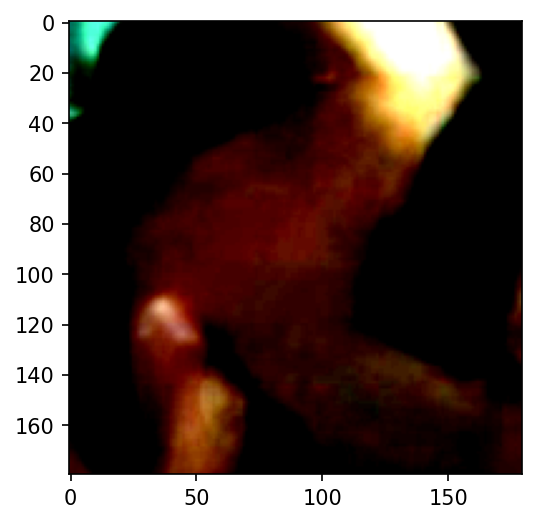

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


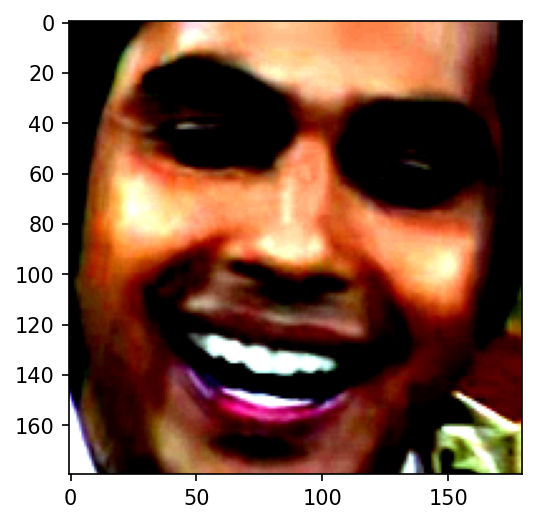

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


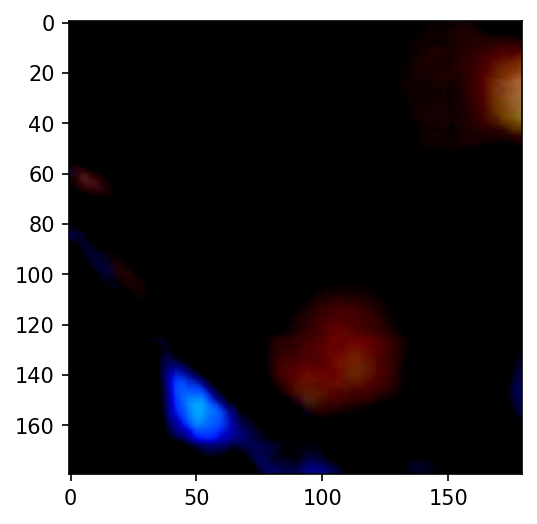

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


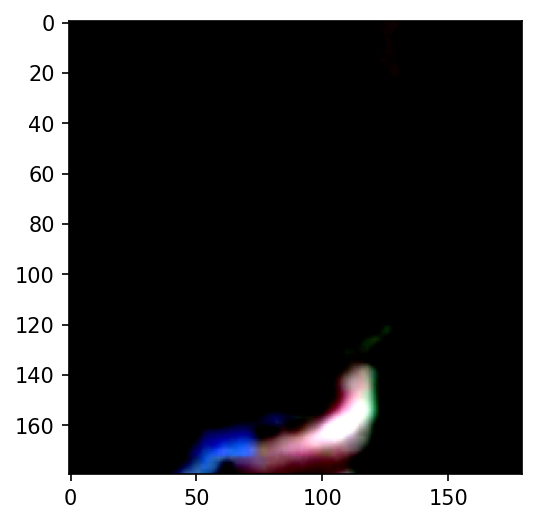

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


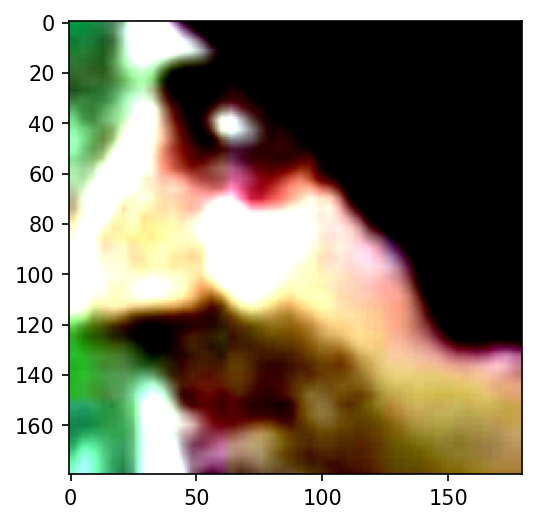

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


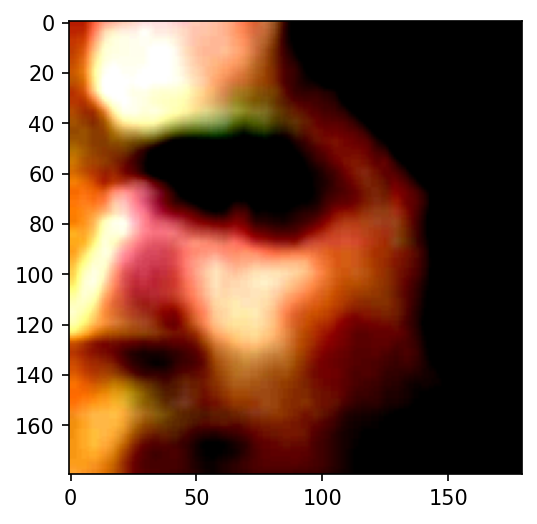

In [ ]:
model.eval()
tacc, tloss = evaluate(model, test_loader, True, loss_fnc, desired, sensitivity=True) # desired
print (round(tacc*100, 2), tloss)

No hypertuning, standard models, lr=0.03 (sheldon 0.06)
~4min training time

- Leonard: 99.3% 
- Penny: 99.5%
- Raj: 99.3%
- Sheldon: 98.5%
- Wolowitz: 99.4%


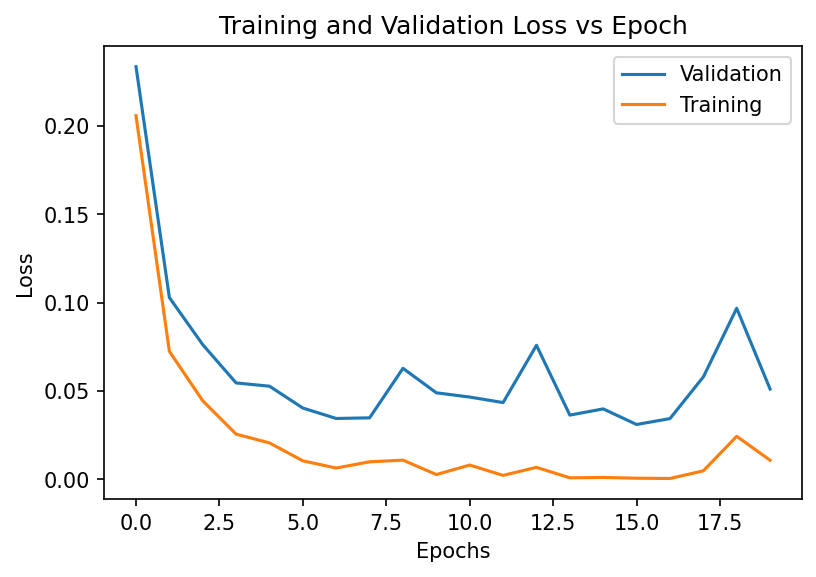

In [ ]:
nRec = range(len(vlosses))
plt.plot(nRec, vlosses, label="Validation")
plt.plot(nRec, tlosses, label="Training")
plt.title("Training and Validation Loss vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Loss.jpg')
plt.show()

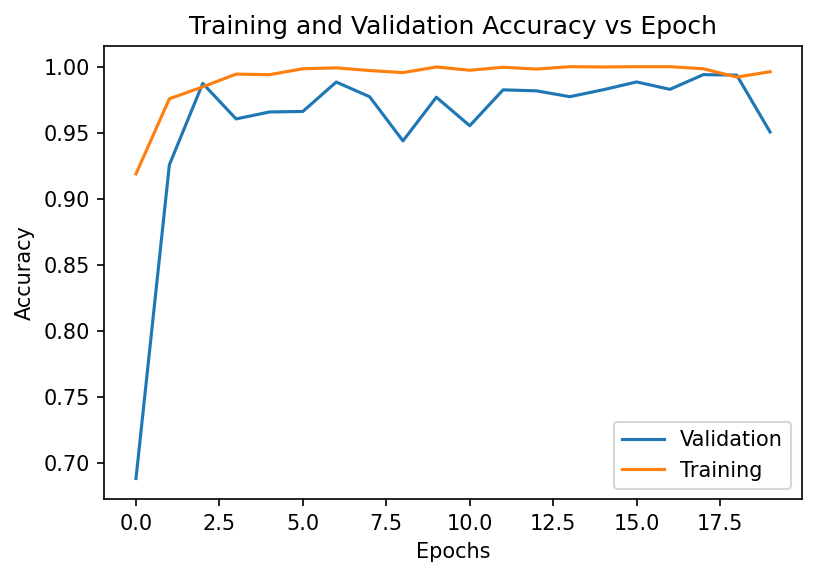

In [ ]:
nRec = range(len(vaccs))
plt.plot(nRec, vaccs, label="Validation")
plt.plot(nRec, accs, label="Training")
plt.title("Training and Validation Accuracy vs Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('Accuracy.jpg')
plt.show()

In [ ]:
twos = torch.ones([6], dtype=torch.long) + 1
twos

tensor([2, 2, 2, 2, 2, 2])

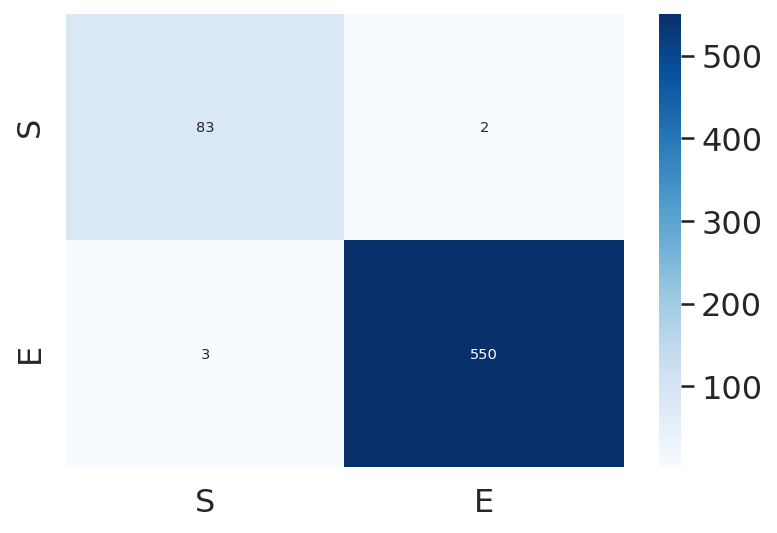

(0.9798136645962733, 0.06597181728907994)

In [ ]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for data in test_loader:
        images, labels = data
        
        for i in range(len(labels)):
            y_true.append(labels[i])
        
        outputs = model(images.type(torch.cuda.FloatTensor))
        labels = labels.type(torch.cuda.LongTensor)
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred += list(predicted.float())
        
y_true = [int(c) for c in y_true]
y_pred = [int(c) for c in y_pred]

# print (y_true, y_pred)

conf_matrix = confusion_matrix(y_true, y_pred)
print (conf_matrix)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame([[83, 2],[3, 550]], index = [i for i in "SE"],
                  columns = [i for i in "SE"])


# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 7}, fmt='g', cmap="Blues") # font size
plt.savefig('Confusion.jpg')
plt.show()

evaluate(model, test_loader, False, loss_fnc)

In [ ]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)

print (input, target, m(input))
output = loss(m(input), target)
output.backward()

In [ ]:
ones = torch.ones([batch_size], dtype=torch.long).cuda()
neg_ones = -1 * ones
twos = ones + 1

labels    = torch.LongTensor([1,1,1,0,0,0,1,1,1]).cuda()
predicted = torch.LongTensor([1,0,1,0,1,1,1,1,1]).cuda()

# Tp should be 5

# (predicted + labels == twos[:len(labels)]).sum().item()
(predicted + labels == twos[:len(labels)]).sum().item()


5